## 0. Overview

In this notebook, we focus on evaluating the following files:
1. Accidents from the "Autoridade Nacional de Segurança Rodóviaria" (ANSR);
     * Accident sheet;
     * Vehicle and driver sheet;
     * Passengers sheet;
     * Pedestrian sheets;
2. Accidents from the "Regime de Sapadores Bombeiros" (RSB);
**ATENÇÃO** 3. Precipitation in Portugal from IPMA;

## 1. Import the required modules

First, we need to import the necessary modules.

In [1]:
import pandas as pd
import numpy as np
import json
from haversine import haversine_vector, Unit
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Load accident data

**`ANSR file`**

1. This file has multiple sheets, so we will import each of the sheets to a different data frame.

In [2]:
ansr_file_path = '../00-data/raw/Acidentes_ANSR_2019_desafio_lxdatalab_2020_21.xlsx'

ansr_accidents = pd.read_excel(ansr_file_path, sheet_name='acidentes')
ansr_vehicle_driver = pd.read_excel(ansr_file_path, sheet_name='veíc-cond')
ansr_passengers = pd.read_excel(ansr_file_path, sheet_name='passageiros')

**`RSB file`**
1. The second file has a single sheet with accident information.

In [3]:
rsb_file_path = '../00-data/raw/RSB_AcidentesRodoviarios2019.csv'

rsb_accidents = pd.read_csv(rsb_file_path, sep=';', encoding='cp1252')

## 3. Data exploration

Here we explore the different data frames, to evaluate data quality and possible errors. <br>
This exploration will serve as a base for the cleaning phase in the next chapter.

### 3.1. ANSR accidents evaluation

**`Data shape`**

In [4]:
ansr_accidents.shape

(2768, 37)

We have information about almost 3000 accidents.

**`Data overview`**

In [5]:
ansr_accidents.head(3).T

,0,1,2
IdAcidente,20191648491,20191648498,20191648520
Datahora,2019:01:02 15:10:00,2019:01:02 16:45:00,2019:01:02 13:05:00
Dia da Semana,Quarta-Feira,Quarta-Feira,Quarta-Feira
Sentidos,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO
Latitude GPS,38.768367,38.719096,38.728779
Longitude GPS,-9.172899,-9.15613,-9.147518
Via Trânsito,Direita,Esquerda,Central
Localizações,Dentro das localidades,Dentro das localidades,Dentro das localidades
Freguesia,Lumiar,Campo de Ourique,Avenidas Novas
Pov. Proxima,Lisboa,Lisboa,Lisboa


* We have a lot of descriptive features, regarding the accident;
* It's not clear which some of the features represent (VM, FG, and FL for example);
* We have information on the type of accidents that may help identification of different root causes for different types of accidents.

**`Missing values`**

In [6]:
ansr_accidents.isna().sum().sort_values(ascending=False).head(7)

Km                 2519
Pov. Proxima       1322
Latitude GPS        945
Longitude GPS       945
Num arruamento      259
Nome arruamento     253
IdAcidente            0
dtype: int64

* We have some features with missing values;
* The missing values of latitude and longitude may represent a major problem when performing geolocation evaluations. This missing value represents 30% of the data.

**`Statistical evaluation`**

In [7]:
ansr_accidents.describe()

,IdAcidente,Latitude GPS,Longitude GPS,VM,FG,FL,Km
count,2.768000e+03,1823.000000,1823.000000,2768.000000,2768.000000,2768.000000,249.000000
mean,2.019191e+10,38.733288,-9.150429,0.002890,0.024205,1.177384,4.058783
std,1.372972e+06,0.063683,0.062830,0.053692,0.160612,0.607121,3.264365
min,2.019165e+10,37.017289,-9.413910,0.000000,0.000000,0.000000,0.000000
25%,2.019167e+10,38.718220,-9.170539,0.000000,0.000000,1.000000,1.500000
50%,2.019172e+10,38.734634,-9.150388,0.000000,0.000000,1.000000,3.135000
75%,2.019177e+10,38.751966,-9.135339,0.000000,0.000000,1.000000,6.200000
max,2.020187e+10,38.918566,-7.413290,1.000000,2.000000,9.000000,18.000000


* IdAccidente should be converted to index;
* A value with a latitude of 37 seems a bit off and needs to be evaluated;
* Longitude also seems to presents some outliers.

In [8]:
ansr_accidents.describe(include='O').T

,count,unique,top,freq
Datahora,2768,2708,2019:03:22 09:00:00,3
Dia da Semana,2768,7,Sexta-Feira,478
Sentidos,2768,3,NÃO DEFINIDO,1852
Via Trânsito,2768,3,Direita,2025
Localizações,2768,2,Dentro das localidades,2596
Freguesia,2768,24,Avenidas Novas,244
Pov. Proxima,1446,16,Lisboa,1390
Tipo Natureza,2768,3,Colisão,1573
Natureza,2768,17,Atropelamento de peões,640
Traçado 1,2768,3,Recta,2327


* Most of these features have a lot of values and need to be further evaluated;
* Some of the features present a high cardinality and probably need to be binned.

**`Outliers evaluation`**

In [9]:
ansr_accidents.kurtosis()

IdAcidente        48.198142
Latitude GPS     514.899085
Longitude GPS    444.147973
VM               341.621845
FG                51.981671
FL                27.308069
Km                 0.230193
dtype: float64

* As we saw previously latitude and longitude present a high kurtosis and probably present some outliers; 
* Regarding VM, FG, and FL we don't know what they represent and so we will remove them in the future.

**`Outliers visualization`**

We focus now on latitude and longitude.

<AxesSubplot:xlabel='Longitude GPS'>

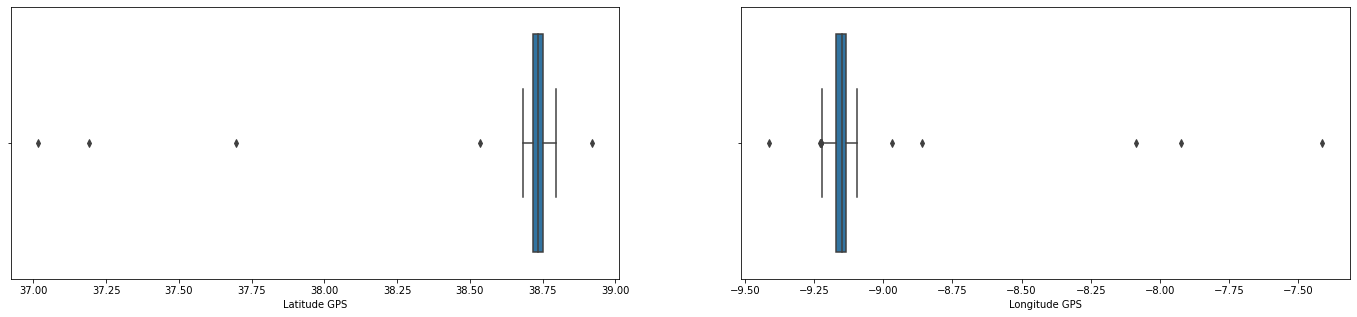

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(24, 5))
sns.boxplot(data = ansr_accidents, x = 'Latitude GPS', ax = axes[0])
sns.boxplot(data = ansr_accidents, x = 'Longitude GPS', ax = axes[1])

<AxesSubplot:xlabel='Longitude GPS', ylabel='Latitude GPS'>

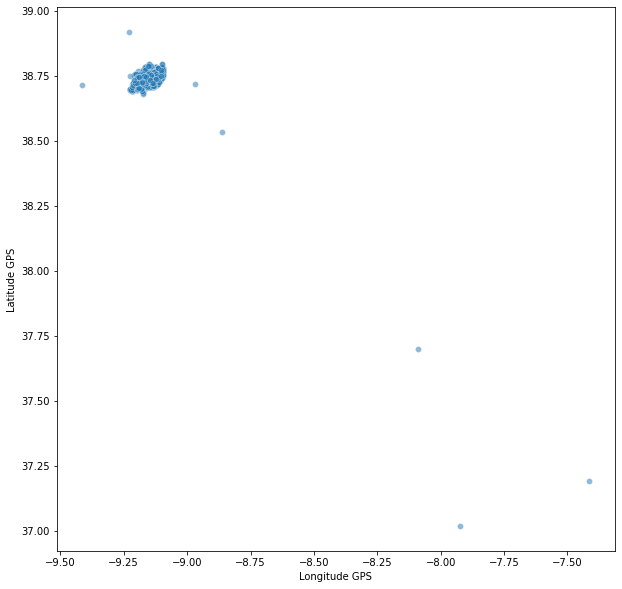

In [11]:
plt.figure(figsize = (10, 10))
sns.scatterplot(data = ansr_accidents, y = 'Latitude GPS', x = 'Longitude GPS', alpha = 0.5)

* Has expected we have some really large outliers;
* When plotting the latitude and longitude we can't see the city of Lisbon meaning that the outliers are really big;
* Let's try to remove some and reevaluate.

**`Removing the outliers reevaluating`**

In [12]:
ansr_accidents_no_outliers = (
    ansr_accidents
    .loc[lambda x: x['Latitude GPS'] > 38.55]
    .loc[lambda x: x['Latitude GPS'] < 38.80]
    .loc[lambda x: x['Longitude GPS'] > -9.30]
    .loc[lambda x: x['Longitude GPS'] < -9.00]
)

<AxesSubplot:xlabel='Longitude GPS'>

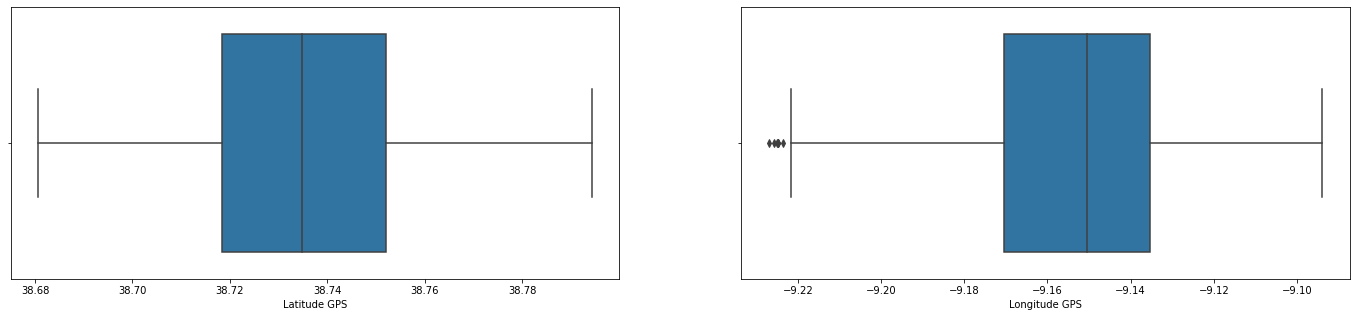

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(24, 5))
sns.boxplot(data = ansr_accidents_no_outliers, x = 'Latitude GPS', ax = axes[0])
sns.boxplot(data = ansr_accidents_no_outliers, x = 'Longitude GPS', ax = axes[1])

<AxesSubplot:xlabel='Longitude GPS', ylabel='Latitude GPS'>

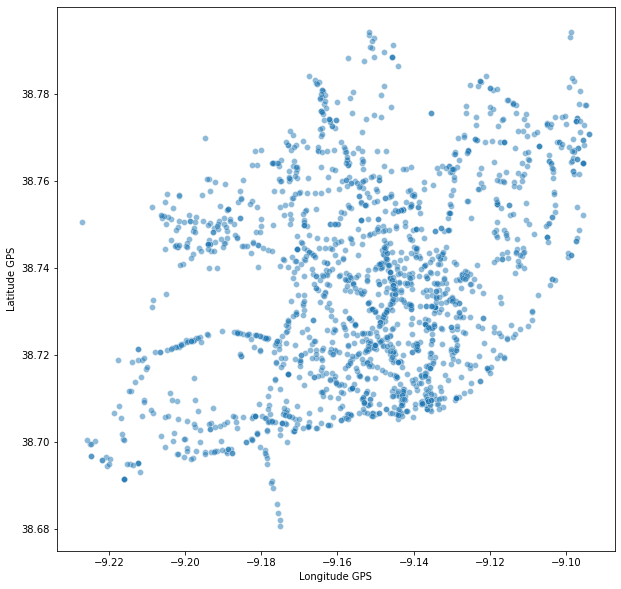

In [14]:
plt.figure(figsize = (10, 10))
sns.scatterplot(data = ansr_accidents_no_outliers, y = 'Latitude GPS', x = 'Longitude GPS', alpha = 0.5)

* In the boxplot we can now see that we don't have any more extreme outliers;
* When plotting the latitude and longitude we can now see the city of Lisbon.

**`Accident type evaluation`**

In [15]:
ansr_accidents['Tipo Natureza'].value_counts(normalize=True).round(2)

Colisão          0.57
Atropelamento    0.24
Despiste         0.19
Name: Tipo Natureza, dtype: float64

In [16]:
column = 'Natureza'
ansr_accidents[column].value_counts()

Atropelamento de peões                                          640
Colisão lateral com outro veículo em movimento                  560
Colisão traseira com outro veículo em movimento                 363
Colisão com outras situações                                    355
Despiste sem dispositivo de retenção                            329
Despiste com dispositivo de retenção                            109
Colisão choque em cadeia                                         97
Colisão com veiculo ou obstáculo na faixa de rodagem             74
Colisão frontal                                                  72
Colisão com fuga                                                 52
Despiste com colisão com veículo imobil. ou obstáculo            48
Atropelamento com fuga                                           33
Despiste com capotamento                                         20
Despiste simples                                                 11
Despiste com fuga                               

* Most of the accidents are collision accidents;
* However, run-over accidents also have a high incident rate and probably have different characteristics that should be evaluated.

**`Duplicated accidents`**

In [17]:
ansr_accidents.drop(['IdAcidente'], axis = 1).duplicated().sum()

0

* We have no duplicated values;

**`Categorical features`**

In this phase, we focus on evaluating the categorical features and evaluate possible corrections.

In [18]:
column = 'Sentidos'
ansr_accidents[column].value_counts()

NÃO DEFINIDO                               1852
No sentido crescente da quilometragem       477
No sentido decrescente da quilometragem     439
Name: Sentidos, dtype: int64

* There are a lot of undefined values so this feature should probably be removed.

In [19]:
column = 'Via Trânsito'
ansr_accidents[column].value_counts()

Direita     2025
Esquerda     492
Central      251
Name: Via Trânsito, dtype: int64

* No need to do corrections on this feature;

In [20]:
column = 'Localizações'
ansr_accidents[column].value_counts()

Dentro das localidades    2596
Fora das localidades       172
Name: Localizações, dtype: int64

* No need to do corrections on this feature;

In [21]:
column = 'Freguesia'
ansr_accidents[column].value_counts()

Avenidas Novas             244
Alvalade                   227
Lumiar                     203
São Domingos de Benfica    178
Santa Maria dos Olivais    170
Alcântara                  162
Arroios                    138
Campolide                  126
Estrela                    125
Marvila                    113
Belém                      111
Benfica                    107
Parque das Nações          103
Santo António              102
Santa Maria Maior           99
Areeiro                     85
Campo de Ourique            84
Misericórdia                83
Ajuda                       73
Carnide                     72
Penha de França             66
Santa Clara                 42
São Vicente                 31
Beato                       24
Name: Freguesia, dtype: int64

* No need to do corrections on this feature;

In [22]:
column = 'Pov. Proxima'
ansr_accidents[column].value_counts()

Lisboa                                                      1390
Ajuda                                                         29
MONSANTO                                                       6
Alcântara                                                      3
Lisboa.                                                        3
ALCANTARA                                                      3
Alfragide                                                      2
AJUDA.                                                         2
Carnaxide                                                      1
Alges                                                          1
Monsanto.                                                      1
Ajuda/Monsanto                                                 1
Ajuda/Belém                                                    1
Belém                                                          1
Acesso da rotunda da Expo Ford (Av. Dom João II) ao IC 2       1
Acesso do IP 7 à Rotunda 

* Most of the accidents happened in Lisbon. This feature is not very informative and should be removed.

In [23]:
column = 'Traçado 1'
ansr_accidents[column].value_counts()

Recta           2327
Curva            422
NÃO DEFINIDO      19
Name: Traçado 1, dtype: int64

* Some values are not defined. However, due to the low number, we will probably use the mode to correct these values.

In [24]:
column = 'Traçado 2'
ansr_accidents[column].value_counts()

Em patamar        1777
Com inclinação     958
NÃO DEFINIDO        24
Em Lomba             9
Name: Traçado 2, dtype: int64

* Some values are not defined. However, due to the low number, we will probably use the mode to correct these values.

In [25]:
column = 'Traçado 3'
ansr_accidents[column].value_counts()

Berma pavimentada            1702
Sem berma ou impraticável     996
Berma não pavimentada          36
NÃO DEFINIDO                   34
Name: Traçado 3, dtype: int64

* Some values are not defined. However, due to the low number, we will probably use the mode to correct these values.

In [26]:
column = 'Traçado 4'
ansr_accidents[column].value_counts()

Em plena via                   2631
No passeio                       41
NÃO DEFINIDO                     30
Em parque de estacionamento      26
Em via ou pista reservada        25
Na berma                         15
Name: Traçado 4, dtype: int64

* Some values are not defined. However, due to the low number, we will probably use the mode to correct these values.

In [27]:
column = 'Estado Conservação'
ansr_accidents[column].value_counts()

Em estado regular    1684
Em bom estado        1011
Em mau estado          45
NÃO DEFINIDO           28
Name: Estado Conservação, dtype: int64

* Some values are not defined. However, due to the low number, we will probably use the mode to correct these values.
* Also in this case it seems that the good state and regular state represent the same, so we will also uniformize this level.

In [28]:
column = 'Características Tecnicas'
ansr_accidents[column].value_counts()

Estrada sem separador    1552
Outra via                1115
Auto-estrada              101
Name: Características Tecnicas, dtype: int64

* No need to do corrections on this feature;

In [29]:
column = 'Reg Circulação'
ansr_accidents[column].value_counts()

Sentido único    1622
Dois sentidos    1142
Reversível          4
Name: Reg Circulação, dtype: int64

* No need to do corrections on this feature;

In [30]:
column = 'Marca Via'
ansr_accidents[column].value_counts()

Com marcas - separadoras de sentido e de vias de trânsito    1785
Sem marcas rodoviárias ou pouco visíveis                      705
Com marcas - separadoras de sentido de trânsito               255
NÃO DEFINIDO                                                   23
Name: Marca Via, dtype: int64

* Some values are not defined. However, due to the low number, we will probably use the mode to correct these values.
* We will also simplify the feature and only consider the first part: "with markings" and "without markings".

In [31]:
column = 'Obstáculos'
ansr_accidents[column].value_counts()

Inexistentes                    2677
NÃO DEFINIDO                      40
Correctamente sinalizados         36
Não sinalizados                    9
Insuficentemente sinalizados       6
Name: Obstáculos, dtype: int64

* Some values are not defined. However, due to the low number, we will probably use the mode to correct these values.
* We will also simplify the feature to only consider the existence and non-existence of obstacles.

In [32]:
column = 'Sinais'
ansr_accidents[column].value_counts()

Outros                        1815
NÃO DEFINIDO                   531
Passagem de peões              300
Cedência de passagem           100
Stop                            20
Proibição de ultrapassagem       2
Name: Sinais, dtype: int64

* Here we will make some corrections. The non-defined values will go to the other category.
* The pedestrian crossing will continue to have a solo level;
* The other ones seem very similar so they will be converted to pass-through;

In [33]:
column = 'Sinais Luminosos'
ansr_accidents[column].value_counts()

Inexistentes               1883
A funcionar normalmente     798
NÃO DEFINIDO                 38
Desligada                    29
Intermitente                 20
Name: Sinais Luminosos, dtype: int64

* Here we will also make some corrections. Turn off will be converted to inexistent;
* The ones that are not defined will be converted to the mode;
* the other two will be kept;

In [34]:
column = 'Tipo Piso'
ansr_accidents[column].value_counts()

Betuminoso          2510
Calçada              202
Betão de cimento      30
NÃO DEFINIDO          22
Terra batida           4
Name: Tipo Piso, dtype: int64

* The ones that are not defined will be converted to the mode;
* The ones that represent lower groups will be converted to "outros pisos"

In [35]:
column = 'Intersecção Vias'
ansr_accidents[column].value_counts()

Fora da intersecção             1688
Em entroncamento                 452
Em cruzamento                    387
NÃO DEFINIDO                     104
Em rotunda                        57
Em via de aceleração              51
Em ramo de ligação - entrada      18
Em via de desaceleração           11
Name: Intersecção Vias, dtype: int64

* The ones that are not defined will be converted to the mode;
* The "cruzamentos" and "entroncametnos" will be converter to a level;
* "Rotundas" will be kept as a level;
* The last three groups will be converted to "outros";

In [36]:
column = 'Factores Atmosféricos'
ansr_accidents[column].value_counts()

Bom tempo       2323
Chuva            418
NÃO DEFINIDO      27
Name: Factores Atmosféricos, dtype: int64

* The ones that are not defined will be converted to the mode;

In [37]:
column = 'Luminosidade'
ansr_accidents[column].value_counts()

Em pleno dia             1830
Noite, com iluminação     778
Aurora ou crepúsculo      128
Noite, sem iluminação      16
NÃO DEFINIDO               10
Sol escandeante             6
Name: Luminosidade, dtype: int64

* The ones that are not defined will be converted to the mode;

In [38]:
column = 'Cond Aderência'
ansr_accidents[column].value_counts()

Seco e limpo                              2246
Molhado                                    427
Húmido                                      44
NÃO DEFINIDO                                34
Com óleo                                     9
Com água acumulada na faixa de rodagem       4
Com gravilha ou areia                        3
Com lama                                     1
Name: Cond Aderência, dtype: int64

* The ones that are not defined will be converted to the mode;
* "Húmido" and "Com água acumulada na faixa de rodagem" will be converted to "Molhado"
* The smaller groups will be converted to "outros";

In [39]:
column = 'Tipos Vias'
ansr_accidents[column].value_counts()

Arruamento                      2515
IP- Itinerário Principal         103
A  - Auto-Estrada                101
IC - Itinerário Complementar      36
Outra Via                         10
PNT - Ponte                        3
Name: Tipos Vias, dtype: int64

* No need to corrections on this feature;

In [40]:
column = 'Via'
ansr_accidents[column].value_counts()

0             2525
IP7            103
A5              56
A2              44
IC17            22
IC19            14
PNT25ABRIL       3
A1               1
Name: Via, dtype: int64

* Most of the streets are not defined, so this feature will be removed;

In [41]:
column = 'Localização 2'
ansr_accidents[column].value_counts()

Sem GPS - não estimado    944
Localização GPS           924
Sem GPS - estimado        900
Name: Localização 2, dtype: int64

* This feature is non-informative for this study so it will be removed;

### 3.2. ANSR veichle and drivers evaluation

**`Data shape`**

In [42]:
ansr_vehicle_driver.shape

(4834, 18)

We have information of almost 5000 drivers and vehicles information.

**`Data overview`**

In [43]:
ansr_vehicle_driver.head(3).T

,0,1,2
IdAcidente,20191725599,20191794772,20191677921
Datahora,2019:06:10 11:30:00,2019:10:07 09:50:00,2019:05:17 08:40:00
Id. Veiculo,2,2,3
Categoria Veículos,Automóvel ligeiro,Automóvel ligeiro,Automóvel ligeiro
Tipo Veiculo,Passageiros,Mercadorias,Mercadorias
Idade,32.0,51.0,26.0
Sexo,Feminino,Masculino,Masculino
Lesões a 30 dias,Ileso,Ileso,Ileso
Acessórios Condutores,Cinto de segurança,Cinto de segurança,NÃO DEFINIDO
Acções Condutores,Travagem brusca,Travagem brusca,Travagem brusca


* We have a lot of descriptive features, regarding the veichles and drivers;
* We continue to have an Id of the accident and now we have also an Id of the veichle.

**`Missing values`**

In [44]:
ansr_vehicle_driver.isna().sum().sort_values(ascending=False).head(2)

Idade         204
IdAcidente      0
dtype: int64

* Only the age has missing values, that have to be treated in the next steps.

**`Statistical evaluation`**

In [45]:
ansr_vehicle_driver.describe()

,IdAcidente,Id. Veiculo,Idade
count,4.834000e+03,4834.000000,4630.000000
mean,2.019193e+10,1.564750,41.275162
std,1.453167e+06,0.820318,15.259174
min,2.019165e+10,1.000000,9.000000
25%,2.019167e+10,1.000000,29.000000
50%,2.019172e+10,1.000000,39.000000
75%,2.019177e+10,2.000000,51.000000
max,2.020187e+10,11.000000,93.000000


* We have a driver with 9 year? Will consider it but it seems very odd;

In [46]:
ansr_vehicle_driver.describe(include='O').T

,count,unique,top,freq
Datahora,4834,2708,2019:08:02 12:09:00,11
Categoria Veículos,4834,13,Automóvel ligeiro,3349
Tipo Veiculo,4834,6,Passageiros,3054
Sexo,4834,3,Masculino,3486
Lesões a 30 dias,4834,4,Ileso,2828
Acessórios Condutores,4834,5,Cinto de segurança,3047
Acções Condutores,4834,18,Em marcha normal,3625
Inf. Comp. a Acções e Manobras,4834,13,Não identificada,3727
Licença Condução,4834,7,Com licença/ carta adequada ao veiculo,4245
Tempo Condução Continuada,4834,6,Ignorada,3888


* Most of the features have a lot of values and need to be further evaluated;
* Some of the features present a high cardinality and probably need to be binned.

**`Age evaluation`**

In [47]:
ansr_vehicle_driver['Idade'].sort_values().value_counts().sort_index().head(10)

9.0      1
11.0     1
12.0     1
13.0     1
14.0     8
15.0     7
16.0     9
17.0    14
18.0    28
19.0    55
Name: Idade, dtype: int64

* Ok it seems that there are a lot of drivers that are still under are. 
* Although, this could happen for some motorcycles 9 years for example is always illegal.

**`Duplicated accidents`**

In [48]:
ansr_vehicle_driver.drop(['IdAcidente', 'Id. Veiculo'], axis = 1).duplicated().sum()

14

* We have some duplicated values that have to be evaluated.

In [49]:
ansr_vehicle_driver.loc[ansr_vehicle_driver.drop(['IdAcidente', 'Id. Veiculo'], axis = 1).duplicated(keep=False)].sort_values(by='Datahora')

,IdAcidente,Datahora,Id. Veiculo,Categoria Veículos,Tipo Veiculo,Idade,Sexo,Lesões a 30 dias,Acessórios Condutores,Acções Condutores,Inf. Comp. a Acções e Manobras,Licença Condução,Tempo Condução Continuada,Teste Alcool,Carga Lotação,Certificado Adr,Inspecção Periódica,Seguros
714,20191660827,2019:02:07 17:30:00,1,Automóvel ligeiro,Passageiros,NaN,NÃO DEFINIDO,Ileso,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,Sem carga,NÃO DEFINIDO,Válida,Com seguro
715,20191660827,2019:02:07 17:30:00,3,Automóvel ligeiro,Passageiros,NaN,NÃO DEFINIDO,Ileso,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,Sem carga,NÃO DEFINIDO,Válida,Com seguro
772,20191661253,2019:02:09 22:45:00,3,Automóvel ligeiro,Passageiros,NaN,NÃO DEFINIDO,Ileso,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,Sem carga,NÃO DEFINIDO,Válida,Com seguro
773,20191661253,2019:02:09 22:45:00,4,Automóvel ligeiro,Passageiros,NaN,NÃO DEFINIDO,Ileso,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,Sem carga,NÃO DEFINIDO,Válida,Com seguro
539,20191667000,2019:03:15 19:00:00,2,Motociclo cilindrada <= 125cc,NÃO DEFINIDO,NaN,NÃO DEFINIDO,Ileso,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,Não submetido condutor não contactado na altur...,Sem carga,NÃO DEFINIDO,Não obrigatória,Com seguro
549,20191667000,2019:03:15 19:00:00,3,Motociclo cilindrada <= 125cc,NÃO DEFINIDO,NaN,NÃO DEFINIDO,Ileso,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,Não submetido condutor não contactado na altur...,Sem carga,NÃO DEFINIDO,Não obrigatória,Com seguro
550,20191667000,2019:03:15 19:00:00,5,Motociclo cilindrada <= 125cc,NÃO DEFINIDO,NaN,NÃO DEFINIDO,Ileso,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,Não submetido condutor não contactado na altur...,Sem carga,NÃO DEFINIDO,Não obrigatória,Com seguro
551,20191667000,2019:03:15 19:00:00,6,Motociclo cilindrada <= 125cc,NÃO DEFINIDO,NaN,NÃO DEFINIDO,Ileso,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,Não submetido condutor não contactado na altur...,Sem carga,NÃO DEFINIDO,Não obrigatória,Com seguro
552,20191667000,2019:03:15 19:00:00,7,Motociclo cilindrada <= 125cc,NÃO DEFINIDO,NaN,NÃO DEFINIDO,Ileso,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,Não submetido condutor não contactado na altur...,Sem carga,NÃO DEFINIDO,Não obrigatória,Com seguro
1805,20191695073,2019:03:30 19:33:00,4,Automóvel ligeiro,Passageiros,51.0,Masculino,Ileso,Cinto de segurança,Em marcha normal,Obstáculo imprevisto na faixa de rodagem,Com licença/ carta adequada ao veiculo,Menos de 1 hora,Submetido ao teste do álcoolemia,Sem carga,NÃO DEFINIDO,Válida,Com seguro


* It seems that there are some repeated data but the vehicle information is different;
* Although, unlikely we opted to keep this information since it is difficult to confirm that these are repeated entries.

**`Categorical features`**

In this phase, we focus on evaluating the categorical features and evaluate possible corrections.

In [50]:
column = 'Categoria Veículos'
ansr_vehicle_driver[column].value_counts()

Automóvel ligeiro                3349
Motociclo cilindrada <= 125cc     710
Motociclo cilindrada > 125cc      338
Automóvel pesado                  118
Ciclomotor                        114
Velocípede                         87
Velocípede com motor               79
Triciclo                           23
Veículo sobre carris                8
Desconhecido                        3
Quadriciclo                         2
NÃO DEFINIDO                        2
Veículo agrícola                    1
Name: Categoria Veículos, dtype: int64

* No defined vehicles will be substituted by the mode, same as the unknowns;
* "Velocipedes" will be put on one group;
* The smaller groups will all be put in a "Outros" group.

In [51]:
column = 'Tipo Veiculo'
ansr_vehicle_driver[column].value_counts()

Passageiros         3054
NÃO DEFINIDO        1391
Mercadorias          331
Veículo Especial      39
Misto                 13
Tractor                6
Name: Tipo Veiculo, dtype: int64

* This group will for now be removed since the information of vehicle category is sufficient for the next steps;

In [52]:
column = 'Sexo'
ansr_vehicle_driver[column].value_counts()

Masculino       3486
Feminino        1144
NÃO DEFINIDO     204
Name: Sexo, dtype: int64

* No defined gender will be substituted by the mode;

In [53]:
column = 'Lesões a 30 dias'
ansr_vehicle_driver[column].value_counts()

Ileso           2828
Ferido leve     1972
Ferido grave      30
Morto              4
Name: Lesões a 30 dias, dtype: int64

* This feature doesn't need corrections;

In [54]:
column = 'Acessórios Condutores'
ansr_vehicle_driver[column].value_counts()

Cinto de segurança           3047
Capacete                     1072
NÃO DEFINIDO                  488
Isento                        159
Sem uso de cinto/capacete      68
Name: Acessórios Condutores, dtype: int64

* No defined values will be substituted by the mode;
* This feature will be converted to "Seguro" and "Inseguro";

In [55]:
column = 'Acções Condutores'
ansr_vehicle_driver[column].value_counts()

Em marcha normal                                3625
NÃO DEFINIDO                                     304
Parado ou estacionado                            246
Mudança de direcção para a esquerda              231
Mudança de direcção para a direita                86
Marcha atrás                                      68
Início de marcha                                  50
Desvio brusco/ saída de fila de trânsito          37
Mudança de via de trânsito para a esquerda        36
Mudança de via de trânsito para a direita         33
Ultrapassagem pela esquerda                       31
Inversão do sentido de marcha                     22
Circulação em sentido oposto ao estabelecido      19
Saída de parqueamento ou de rua particular        18
Travagem brusca                                   11
Atravessando a via                                 9
Ultrapassagem pela direita                         7
Trânsito em filas paralelas                        1
Name: Acções Condutores, dtype: int64

* This feature has a lot of free text information that required a larger treatment.
* For this reason it will be removed.

In [56]:
column = 'Inf. Comp. a Acções e Manobras'
ansr_vehicle_driver[column].value_counts()

Não identificada                                     3727
NÃO DEFINIDO                                          321
Velocidade excessiva para as condições existentes     299
Manobra irregular                                     148
Desrespeito das distâncias de segurança               108
Desrespeito da sinalização vertical                    77
Desrespeito da sinalização semafórica                  67
Obstáculo imprevisto na faixa de rodagem               24
Não sinalização da manobra                             20
Desrespeito das marcas rodoviárias                     16
Abertura de porta                                      15
Encandeamento                                          10
Rebentamento de pneumático                              2
Name: Inf. Comp. a Acções e Manobras, dtype: int64

* This feature has a lot of free text information that required a larger treatment.
* For this reason it will be removed.

In [57]:
column = 'Licença Condução'
ansr_vehicle_driver[column].value_counts()

Com licença/ carta adequada ao veiculo        4245
NÃO DEFINIDO                                   375
Não necessária ao veiculo que conduz           155
Com licença/ carta não adequada ao veiculo      23
Sem licença/carta                               22
Caducada/ suspensa                              11
Em situação de instrução/exame                   3
Name: Licença Condução, dtype: int64

* No defined values will be substituted by the mode;
* Three new values will be created: "Com carta", "Não necessária" and "Sem carta";

In [58]:
column = 'Tempo Condução Continuada'
ansr_vehicle_driver[column].value_counts()

Ignorada           3888
NÃO DEFINIDO        350
De 1 a 3 horas      318
Menos de 1 hora     262
De 3 a 5 horas        9
Mais de 5 horas       7
Name: Tempo Condução Continuada, dtype: int64

* We have a lot of accidents without information for this reason this feature will be removed.

In [59]:
column = 'Teste Alcool'
ansr_vehicle_driver[column].value_counts()

Submetido ao teste do álcoolemia                               4252
NÃO DEFINIDO                                                    206
Não submetido condutor não contactado na altura do acidente     159
Não submetido outra                                             132
Não submetido por lesão ou morte decorrente do acidente          36
Submetido por exame                                              25
Não submetido por fuga                                           11
Não submetido por doença                                         11
Não submetido por recusa                                          2
Name: Teste Alcool, dtype: int64

* No information is given regarding the results of the test so this feature is not informative and will be removed;

In [60]:
column = 'Carga Lotação'
ansr_vehicle_driver[column].value_counts()

Sem carga                  4375
NÃO DEFINIDO                310
Carga bem acondicionada     139
Com lotação excedida         10
Name: Carga Lotação, dtype: int64

* No defined values will be substituted by the mode;

In [61]:
column = 'Certificado Adr'
ansr_vehicle_driver[column].value_counts()

NÃO DEFINIDO    4832
Inexistente        2
Name: Certificado Adr, dtype: int64

* This feature is non-informative and for that reason is removed;

In [62]:
column = 'Inspecção Periódica'
ansr_vehicle_driver[column].value_counts()

Válida             2655
Não obrigatória    1984
NÃO DEFINIDO        156
Sem validade         39
Name: Inspecção Periódica, dtype: int64

* No defined values will be substituted by the mode;

In [63]:
column = 'Seguros'
ansr_vehicle_driver[column].value_counts()

Com seguro      4522
NÃO DEFINIDO     119
Isento           114
Sem seguro        79
Name: Seguros, dtype: int64

* No defined values will be substituted by the mode;

### 3.3. ANSR passanger evaluation

**`Data shape`**

In [64]:
ansr_passengers.shape

(631, 8)

* We have information about almost 700 passengers.

**`Data overview`**

In [65]:
ansr_passengers.head(3).T

,0,1,2
IdAcidente,20201823347,20201825716,20201824448
Datahora,2019:12:18 13:00:00,2019:12:30 13:00:00,2019:12:20 21:20:00
Id. Veículo,2,2,1
Id. Passageiro,1,1,1
Idade,22,73,26
Sexo,Feminino,Feminino,Feminino
Lesões a 30 dias,Ferido leve,Ferido leve,Ferido leve
Acessórios Passageiro,C/ capacete/ cinto segurança,C/ capacete/ cinto segurança,C/ capacete/ cinto segurança


* We continue to have an Id of the accident and vehicle, and now also have an id of the passenger.
* Most of the info is regarding the passenger;

**`Missing values`**

In [66]:
ansr_passengers.isna().sum().sort_values(ascending=False).head(2)

IdAcidente    0
Datahora      0
dtype: int64

* No missing values.

**`Statistical evaluation`**

In [67]:
ansr_passengers.describe()

,IdAcidente,Id. Veículo,Id. Passageiro,Idade
count,6.310000e+02,631.000000,631.000000,631.000000
mean,2.019199e+10,1.602219,1.304279,36.942948
std,1.637977e+06,0.648756,0.753382,21.194636
min,2.019165e+10,1.000000,1.000000,1.000000
25%,2.019167e+10,1.000000,1.000000,22.000000
50%,2.019171e+10,2.000000,1.000000,31.000000
75%,2.019176e+10,2.000000,1.000000,53.000000
max,2.020183e+10,6.000000,8.000000,95.000000


* Everything ok with the data.

In [68]:
ansr_passengers.describe(include='O').T

,count,unique,top,freq
Datahora,631,478,2019:04:07 13:10:00,8
Sexo,631,2,Feminino,409
Lesões a 30 dias,631,3,Ferido leve,627
Acessórios Passageiro,631,4,C/ capacete/ cinto segurança,510


* At the first glance everything seems to be ok with the data, but further evaluation is needed.

**`Categorical features`**

In this phase, we focus on evaluating the categorical features and evaluate possible corrections.

In [69]:
column = 'Sexo'
ansr_passengers[column].value_counts()

Feminino     409
Masculino    222
Name: Sexo, dtype: int64

* Everything ok here.

In [70]:
column = 'Lesões a 30 dias'
ansr_passengers[column].value_counts()

Ferido leve     627
Morto             3
Ferido grave      1
Name: Lesões a 30 dias, dtype: int64

* Everything ok here.

In [71]:
column = 'Acessórios Passageiro'
ansr_passengers[column].value_counts()

C/ capacete/ cinto segurança       510
S/ uso capacete/cinto segurança     45
NÃO DEFINIDO                        39
C/ sistema retenção de crianças     37
Name: Acessórios Passageiro, dtype: int64

### 3.4. RSB accidents evalaution

**`Data shape`**

In [72]:
rsb_accidents.shape

(1817, 7)

* We have almost 2000 accidents.

**`Data overview`**

In [73]:
rsb_accidents.head(3).T

,0,1,2
code,42111/O/2019 %ob%367804042019%cb%,60907/O/2019%ob%1161715092019%cb%,51303/O/2019 %ob%466825042019%cb%
position,"{'coordinates': [-9.14692611215691, 38.7303459...","{'coordinates': [-9.15795701650941, 38.7128447...","{'coordinates': [-9.10134876304967, 38.7442906..."
freguesia,Avenidas Novas,Estrela,Marvila
tipologia,2102 - Acidentes - Rodoviários - Com viaturas,2102 - Acidentes - Rodoviários - Com viaturas,2102 - Acidentes - Rodoviários - Com viaturas
dtregisto,04/04/2019 02:13,15/09/2019 00:28,25/04/2019 00:01
dia_registo,04/04/2019,15/09/2019,25/04/2019
hora_registo,2,0,0


* We only have information regarding the location, type, and date of the accident;

**`Missing values`**

In [74]:
rsb_accidents.isna().sum().sort_values(ascending=False).head(2)

freguesia    32
code          0
dtype: int64

* We have a small number of missing values.

**`Statistical evaluation`**

In [75]:
rsb_accidents.describe()

,hora_registo
count,1817.000000
mean,13.433682
std,5.934493
min,0.000000
25%,9.000000
50%,14.000000
75%,18.000000
max,23.000000


* No problems with these features.

In [76]:
rsb_accidents.describe(include='O').T

,count,unique,top,freq
code,1817,1641,62821/O/2019%ob%1347316102019%cb%,4
position,1817,1214,"{'coordinates': [-9.17295260295721, 38.7263530...",42
freguesia,1785,24,Alvalade,149
tipologia,1817,4,2102 - Acidentes - Rodoviários - Com viaturas,1455
dtregisto,1817,1618,30/11/2019 04:36,21
dia_registo,1817,326,30/11/2019,37


* No problems with these features.

**`Outliers evaluation`**

In [77]:
location = pd.DataFrame(rsb_accidents
                        .position
                        .apply(lambda x: json.loads(x.replace("'", '"'))['coordinates'])
                        .to_list(), 
                        columns=['longitude', 'latitude'])

In [78]:
location.kurtosis()

longitude    1814.539297
latitude     1815.469951
dtype: float64

* It seems that we have some outliers in the latitude and longitude.
* Let's evaluate;

**`Outliers visualization`**

We focus now on latitude and longitude.

<AxesSubplot:xlabel='longitude'>

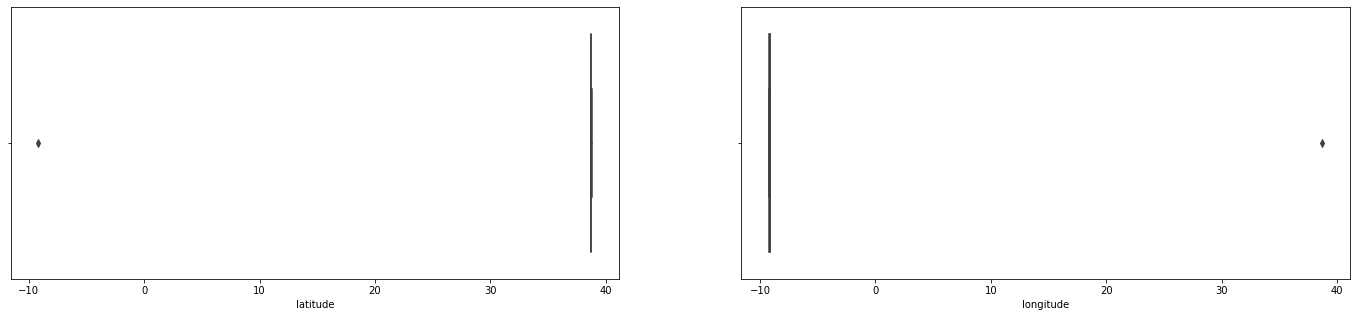

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(24, 5))
sns.boxplot(data = location, x = 'latitude', ax = axes[0])
sns.boxplot(data = location, x = 'longitude', ax = axes[1])

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

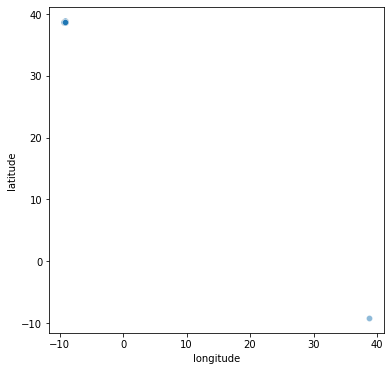

In [80]:
plt.figure(figsize = (6, 6))
sns.scatterplot(data = location, y = 'latitude', x = 'longitude', alpha = 0.5)

* It seems that we have a big outlier that should be removed;

**`Removing outliers evaluation`**

In [81]:
location_no_outliers = (
    location
    .loc[lambda x: x['latitude'] > 0]
)

<AxesSubplot:xlabel='longitude'>

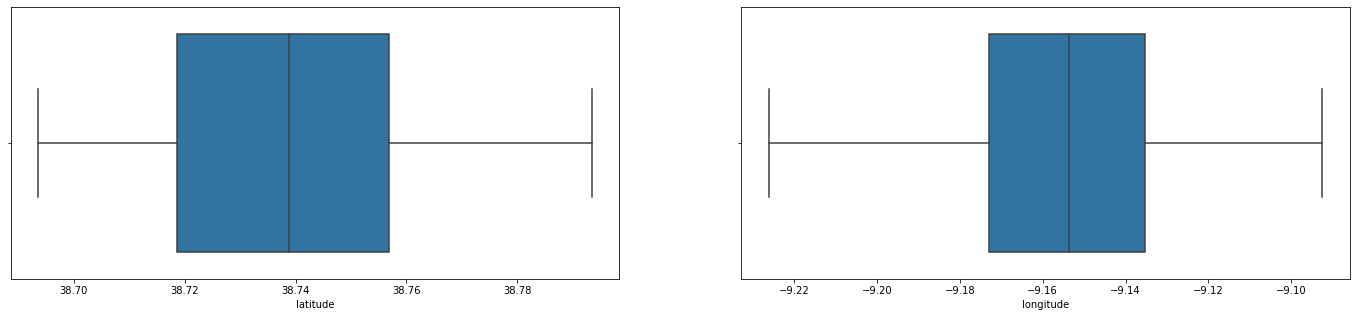

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(24, 5))
sns.boxplot(data = location_no_outliers, x = 'latitude', ax = axes[0])
sns.boxplot(data = location_no_outliers, x = 'longitude', ax = axes[1])

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

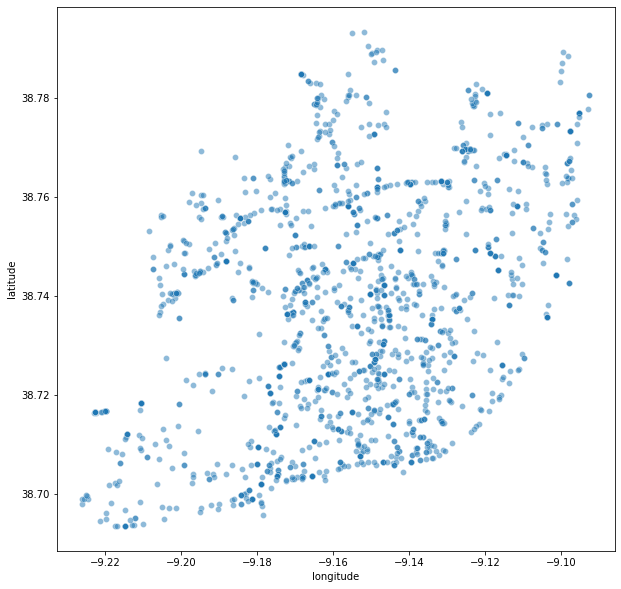

In [83]:
plt.figure(figsize = (10, 10))
sns.scatterplot(data = location_no_outliers, y = 'latitude', x = 'longitude', alpha = 0.5)

* In the boxplot we can now see that we don't have any more extreme outliers;
* When plotting the latitude and longitude we can now see the city of Lisbon.

**`Accident type evaluation`**

In [84]:
rsb_accidents['tipologia'].value_counts(normalize=True).round(2)

2102 - Acidentes - Rodoviários - Com viaturas        0.80
2101 - Acidentes - Rodoviários - Atropelamento       0.10
2103 - Acidentes - Rodoviários - Com Encarcerados    0.07
2103 - Acidentes - Rodoviários - ComEncarcerados     0.03
Name: tipologia, dtype: float64

* Most of the accidents are collision accidents;

**`Duplicated accidents`**

In [85]:
rsb_accidents.drop(['code'], axis = 1).duplicated().sum()

20

* We have 20 duplicated values;

**`Categorical features`**

In this phase, we focus on evaluating the categorical features and evaluate possible corrections.

In [86]:
column = 'freguesia'
rsb_accidents[column].value_counts()

Alvalade                   149
Avenidas Novas             142
Olivais                    141
Campolide                  131
Lumiar                     129
Alcântara                   96
São Domingos de Benfica     95
Marvila                     89
Benfica                     89
Estrela                     78
Belém                       74
Arroios                     66
Santo António               65
Campo de Ourique            58
Santa Maria Maior           57
Parque das Nações           57
Carnide                     52
Misericórdia                44
Areeiro                     42
Penha de França             40
Santa Clara                 28
São Vicente                 24
Ajuda                       21
Beato                       18
Name: freguesia, dtype: int64

* No need to make corrections in the data.
* Since we have the GPS locations we opted to remove this column;

In [87]:
column = 'tipologia'
rsb_accidents[column].value_counts()

2102 - Acidentes - Rodoviários - Com viaturas        1455
2101 - Acidentes - Rodoviários - Atropelamento        185
2103 - Acidentes - Rodoviários - Com Encarcerados     129
2103 - Acidentes - Rodoviários - ComEncarcerados       48
Name: tipologia, dtype: int64

* These accidents are different from the ones in the accident file and need to be uniformized;
* However, we will do that in the next steps.

## 4. Data cleaning

In this step, we clean all the data using the insights gained in the exploration phase and lean it for the preparation phase.

### 4.1. ANSR accidents

#### 4.1.1. User defined functions

In [88]:
def convert_to_datetime(df, date_column, date_format):
    """ Converts the date column to datetime"""
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column], format=date_format)
    return df

#### 4.1.2. Clean the data

In [89]:
clean_ansr_accidents = (
    ansr_accidents
    .set_index('IdAcidente')
    .drop(['Dia da Semana', 'Sentidos', 'Pov. Proxima', 'Num arruamento', 'Km', 'Nome arruamento', 'Via', 'Localização 2', 'VM', 'FG', 'FL'], axis=1)
    .pipe(convert_to_datetime, date_column = 'Datahora', date_format = '%Y:%m:%d %H:%M:%S')
    .fillna(value = {'Latitude GPS': 9999, 'Longitude GPS': 9999})
    .replace({'Traçado 1': {'NÃO DEFINIDO': 'Recta'},
              'Traçado 2': {'NÃO DEFINIDO': 'Em patamar'},
              'Traçado 3': {'NÃO DEFINIDO': 'Berma pavimentada'},
              'Traçado 4': {'NÃO DEFINIDO': 'Em plena via'},
              'Estado Conservação': {'NÃO DEFINIDO': 'Em bom estado',
                                     'Em estado regular': 'Em bom estado'},
              'Marca Via': {'NÃO DEFINIDO': 'Com marcas',
                            'Com marcas - separadoras de sentido e de vias de trânsito': 'Com marcas',
                            'Sem marcas rodoviárias ou pouco visíveis': 'Sem marcas',
                            'Com marcas - separadoras de sentido de trânsito': 'Com marcas'},
              'Obstáculos': {'NÃO DEFINIDO': 'Inexistentes', 
                             'Correctamente sinalizados': 'Existentes',
                             'Não sinalizados': 'Existentes',
                             'Insuficentemente sinalizados': 'Existentes'},
              'Sinais': {'NÃO DEFINIDO': 'Outros',
                         'Stop': 'Cedência de passagem',
                         'Proibição de ultrapassagem': 'Cedência de passagem'},
              'Sinais Luminosos': {'NÃO DEFINIDO': 'Inexistentes',
                                   'Desligada': 'Inexistentes'},
              'Tipo Piso': {'NÃO DEFINIDO': 'Betuminoso',
                            'Betão de cimento': 'Outros pisos',
                            'Terra batida': 'Outros pisos'},
              'Intersecção Vias': {'NÃO DEFINIDO': 'Fora da intersecção',
                                   'Em entroncamento': 'Entrocamento/cruzamento',
                                   'Em cruzamento': 'Entrocamento/cruzamento',
                                   'Em via de aceleração': 'Outras vias',
                                   'Em ramo de ligação - entrada': 'Outras vias',
                                   'Em via de desaceleração': 'Outras vias'},
              'Factores Atmosféricos': {'NÃO DEFINIDO': 'Bom tempo'},
              'Luminosidade': {'NÃO DEFINIDO': 'Em pleno dia'},
              'Cond Aderência': {'NÃO DEFINIDO': 'Seco e limpo',
                                 'Húmido': 'Molhado',
                                 'Com água acumulada na faixa de rodagem': 'Molhado',
                                 'Com óleo': 'Outra aderência',
                                 'Com gravilha ou areia': 'Outra aderência',
                                 'Com lama': 'Outra aderência'}})
)

### 4.2. ANSR veichle and drivers

#### 4.2.1. Clean the data

In [90]:
clean_ansr_vehicle_driver = (
    ansr_vehicle_driver
    .set_index('IdAcidente')
    .drop(['Tipo Veiculo', 'Acções Condutores', 'Tempo Condução Continuada', 'Teste Alcool', 'Certificado Adr', 'Inf. Comp. a Acções e Manobras'], axis=1)
    .pipe(convert_to_datetime, date_column = 'Datahora', date_format = '%Y:%m:%d %H:%M:%S')
    .replace({'Categoria Veículos': {'NÃO DEFINIDO': 'Automóvel ligeiro',
                                     'Velocípede com motor': 'Ciclomotor',
                                     'Veículo sobre carris': 'Outros veículos',
                                     'Quadriciclo': 'Outros veículos',
                                     'Triciclo': 'Outros veículos',
                                     'Veículo agrícola': 'Outros veículos',
                                     'Desconhecido': 'Automóvel ligeiro'},
              'Sexo': {'NÃO DEFINIDO': 'Masculino'},
              'Acessórios Condutores': {'NÃO DEFINIDO': 'Seguro',
                                        'Capacete': 'Seguro',
                                        'Isento': 'Outra segurança',
                                        'Sem uso de cinto/capacete': 'Inseguro',
                                        'Cinto de segurança': 'Seguro'},
              'Licença Condução': {'NÃO DEFINIDO': 'Com carta',
                                   'Não necessária ao veiculo que conduz': 'Outra carta',
                                   'Com licença/ carta adequada ao veiculo': 'Com carta',
                                   'Com licença/ carta não adequada ao veiculo': 'Sem carta',
                                   'Sem licença/carta': 'Sem carta',
                                   'Caducada/ suspensa': 'Sem carta', 
                                   'Em situação de instrução/exame': 'Sem carta'},
              'Carga Lotação': {'NÃO DEFINIDO': 'Sem carga'},
              'Inspecção Periódica': {'NÃO DEFINIDO': 'Válida'},
              'Seguros': {'NÃO DEFINIDO': 'Com seguro'}})
    .fillna({'Idade': ansr_vehicle_driver['Idade'].mean()})
)

### 4.3. ANSR passengers

#### 4.3.1. Clean the data

In [91]:
clean_ansr_passengers = (
    ansr_passengers
    .set_index('IdAcidente')
    .pipe(convert_to_datetime, date_column = 'Datahora', date_format = '%Y:%m:%d %H:%M:%S')
    .replace({'Acessórios Passageiro': {'C/ capacete/ cinto segurança': 'Seguro',
                                        'S/ uso capacete/cinto segurança': 'Inseguro',
                                        'NÃO DEFINIDO': 'Seguro',
                                        'C/ sistema retenção de crianças': 'Seguro'}})
)

### 4.4. RSB accidents

#### 4.4.1. User defined functions

In [92]:
def add_location(df, location_column):
    """ Converts the location json from the second file to columns """
    df = df.copy()
    
    # gets the location
    location = pd.DataFrame(df
                            [location_column]
                            .apply(lambda x: json.loads(x.replace("'", '"'))['coordinates'])
                            .to_list(), 
                            columns=['longitude', 'latitude'])
    
    # merges the location information
    df = pd.concat([df.reset_index(drop=True), 
                    location.reset_index(drop=True)], axis=1)
    
    # drops the position column
    df.drop(columns=[location_column], inplace=True)
    return df

#### 4.4.2. Clean the data

In [93]:
clean_rsb_accidents = (
    rsb_accidents
    .drop(['code', 'freguesia', 'dia_registo', 'hora_registo'], axis=1)
    .drop_duplicates()
    .pipe(convert_to_datetime, date_column = 'dtregisto', date_format = '%d/%m/%Y %H:%M')
    .pipe(add_location, 'position')
)

## 5. Data preparation

In this we prepare the accidents data for the next evaluations: We create 3 files:
* Accident data with geolocation;
* Accident data without geolocation;
* Accident data with police report information;

### 5.1. Accident data with geolocation

**`Prepare data`**

In [94]:
ansr_data = (
    clean_ansr_accidents
    [['Datahora', 'Latitude GPS', 'Longitude GPS', 'Tipo Natureza']]
    .rename(columns = {'Datahora': 'data', 
                       'Latitude GPS': 'latitude',
                       'Longitude GPS': 'longitude',
                       'Tipo Natureza': 'tipo acidente'})
    .query('latitude < 9000')
    .replace({'tipo acidente': {'Colisão' : 'Colisão/Despiste',
                                'Despiste': 'Colisão/Despiste'}})
    .sort_values(by = 'data')
    .reset_index(drop = True)
)

In [95]:
rsb_data = (
    clean_rsb_accidents
    .rename(columns = {'dtregisto': 'data', 
                       'tipologia': 'tipo acidente'})
    .replace({'tipo acidente': {'2102 - Acidentes - Rodoviários - Com viaturas' : 'Colisão/Despiste',
                                '2101 - Acidentes - Rodoviários - Atropelamento' : 'Atropelamento',
                                '2103 - Acidentes - Rodoviários - Com Encarcerados' : 'Colisão/Despiste',
                                '2103 - Acidentes - Rodoviários - ComEncarcerados': 'Colisão/Despiste'}})
    .sort_values(by = 'data')
    .reset_index(drop = True)
)

**`Merge the data`**

In [96]:
data_w_geolocation = pd.concat([ansr_data, rsb_data])

**`Save the data`**

In [97]:
data_w_geolocation.to_parquet('../00-data/processed/data_w_geolocation.parquet')

### 5.2. Accident data without geolocation

**`Prepare data`**

In [98]:
ansr_data = (
    clean_ansr_accidents
    [['Datahora', 'Tipo Natureza']]
    .rename(columns = {'Datahora': 'data', 
                       'Tipo Natureza': 'tipo acidente'})
    .replace({'tipo acidente': {'Colisão' : 'Colisão/Despiste',
                                'Despiste': 'Colisão/Despiste'}})
    .sort_values(by = 'data')
    .reset_index(drop = True)
)

In [99]:
rsb_data = (
    clean_rsb_accidents
    [['dtregisto', 'tipologia']]
    .rename(columns = {'dtregisto': 'data', 
                       'tipologia': 'tipo acidente'})
    .replace({'tipo acidente': {'2102 - Acidentes - Rodoviários - Com viaturas' : 'Colisão/Despiste',
                                '2101 - Acidentes - Rodoviários - Atropelamento' : 'Atropelamento',
                                '2103 - Acidentes - Rodoviários - Com Encarcerados' : 'Colisão/Despiste',
                                '2103 - Acidentes - Rodoviários - ComEncarcerados': 'Colisão/Despiste'}})
    .sort_values(by = 'data')
    .reset_index(drop = True)
)

**`Merge the data`**

In [100]:
data_wo_geolocation = pd.concat([ansr_data, rsb_data])

**`Save the data`**

In [101]:
data_wo_geolocation.to_parquet('../00-data/processed/data_wo_geolocation.parquet')

### 5.3. Accident data with drivers and passengers information

**`Prepare data`**

In [102]:
accidents_drivers = (
    clean_ansr_accidents
    .drop(columns = ['Datahora', 'Latitude GPS', 'Longitude GPS'])
    .merge(clean_ansr_vehicle_driver, left_index=True, right_index=True)
    .rename(columns = {'Acessórios Condutores': 'Acessórios',
                       'Id. Veiculo': 'Id. Veículo'})
    .reset_index()
)

In [103]:
accidents_passengers = (
    accidents_drivers
    .drop(columns = ['Idade', 'Sexo', 'Lesões a 30 dias', 'Acessórios'])
    .merge(clean_ansr_passengers
           .drop(columns = ['Datahora', 'Id. Passageiro'])
           .rename(columns = {'Acessórios Passageiro': 'Acessórios'})
           .reset_index(), on=['IdAcidente', 'Id. Veículo'])
)

**`Merge the data`**

In [104]:
accidents_drivers_passengers = pd.concat([accidents_drivers, accidents_passengers])

**`Save the data`**

In [105]:
accidents_drivers_passengers.to_parquet('../00-data/processed/accidents_drivers_passengers.parquet')